<a href="https://colab.research.google.com/github/ykim879/whats.todays.trend/blob/master/revised_news.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [58]:
import queue
import threading
def eachNewsHeadlines(ID, q):
	response = requests.get('https://newsapi.org/v2/top-headlines?sources=' + ID + '&apiKey=' + key)
	json = response.json()
	if json['status'] != 'ok':
		raise IOError('API key is probably overused :(')
	topNews = []
	topNews.append(ID)
	for elem in json['articles']:
		topNews.append(elem['title'])
	q.put(topNews)

In [59]:
import requests
import pandas as pd
key = '5e74c7cf9e344e3e8c04210f9b75125b'
response = requests.get('https://newsapi.org/v2/sources?'
			   'language=en&country=us&'
			   'apiKey=' + key)
sources = response.json()['sources']
df = pd.DataFrame();
pd.set_option('display.max_columns', 7)
for source in sources:
  row = pd.Series(source)
  df = df.append(row, ignore_index = True)
df.set_index("name", inplace = True)
#collects headline
threads = []
q = queue.Queue()
for id in df['id']:
  t = threading.Thread(target = eachNewsHeadlines, args = (id, q))
  threads.append(t)
  t.start()
for t in threads:
  t.join()
headlines = []
while not q.empty():
  headlines.extend(q.get())

Exception in thread Thread-166:
Traceback (most recent call last):
  File "/Users/yiyeon1/opt/anaconda3/lib/python3.8/site-packages/urllib3/connection.py", line 159, in _new_conn
    conn = connection.create_connection(
  File "/Users/yiyeon1/opt/anaconda3/lib/python3.8/site-packages/urllib3/util/connection.py", line 61, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/Users/yiyeon1/opt/anaconda3/lib/python3.8/socket.py", line 918, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 8] nodename nor servname provided, or not known

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/yiyeon1/opt/anaconda3/lib/python3.8/site-packages/urllib3/connectionpool.py", line 670, in urlopen
    httplib_response = self._make_request(
  File "/Users/yiyeon1/opt/anaconda3/lib/python3.8/site-packages/urllib3/connection

Exception in thread Thread-132:
Traceback (most recent call last):
  File "/Users/yiyeon1/opt/anaconda3/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/Users/yiyeon1/opt/anaconda3/lib/python3.8/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-58-5c882d89a6eb>", line 7, in eachNewsHeadlines
OSError: API key is probably overused :(


     keywords  counts
0       world      53
1         win      52
2       watch      51
3       votes      50
4     vaccine      49
5       trump      48
6  transition      47
7        time      46
8     thehill      45
9        team      44


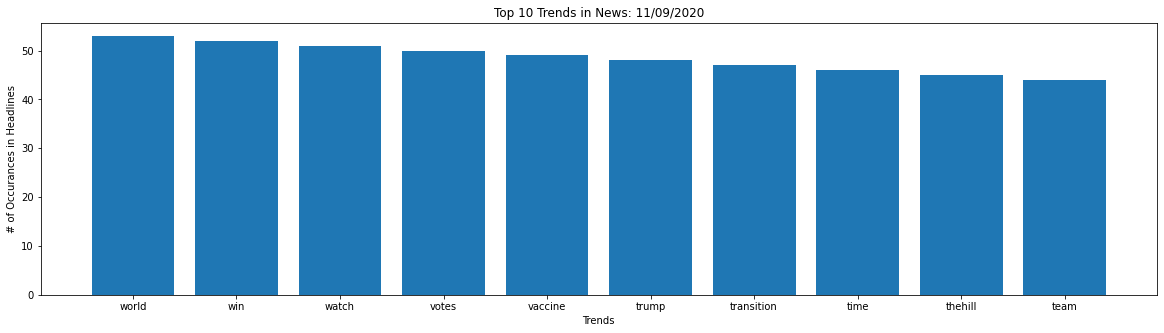

In [60]:
from sklearn.feature_extraction import text
import matplotlib.pyplot as plt
from datetime import date

today = date.today()
d1 = today.strftime("%m/%d/%Y")
stop_words = text.ENGLISH_STOP_WORDS.union({'says','news','new'})
vectorizer1 = text.CountVectorizer(stop_words=stop_words, min_df= 6)
vectorizer2 = text.CountVectorizer(stop_words=stop_words, min_df = 10)
X = vectorizer1.fit_transform(headlines)
keywordDCT = sorted(vectorizer1.vocabulary_.items(), key = lambda x:x[1], reverse = True)
keywordDF = pd.DataFrame(keywordDCT, columns = ['keywords', 'counts'])
print(keywordDF[:10])
plt.figure(figsize=(20,5))
plt.bar(keywordDF['keywords'][:10], keywordDF['counts'][:10])
plt.title('Top 10 Trends in News: ' + d1)
plt.ylabel('# of Occurances in Headlines')
plt.xlabel('Trends')
plt.show()

In [61]:
keywordDF

,keywords,counts
0,world,53
1,win,52
2,watch,51
3,votes,50
4,vaccine,49
5,trump,48
6,transition,47
7,time,46
8,thehill,45
9,team,44


# Data for csv label
1. import the Data
2. change Category to integer values which are 0 to 4
3. split the data to prediction set and test set

In [62]:
import pandas as pd
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_extraction import text
import matplotlib.pyplot as plt
stop_words = text.ENGLISH_STOP_WORDS
data = pd.read_csv('BBC News Train.csv')
print("The original files: Total: 1489 documents with 5 categories")
print(data)

The original files: Total: 1489 documents with 5 categories
      ArticleId                                               Text  \
0          1833  worldcom ex-boss launches defence lawyers defe...   
1           154  german business confidence slides german busin...   
2          1101  bbc poll indicates economic gloom citizens in ...   
3          1976  lifestyle  governs mobile choice  faster  bett...   
4           917  enron bosses in $168m payout eighteen former e...   
...         ...                                                ...   
1485        857  double eviction from big brother model caprice...   
1486        325  dj double act revamp chart show dj duo jk and ...   
1487       1590  weak dollar hits reuters revenues at media gro...   
1488       1587  apple ipod family expands market apple has exp...   
1489        538  santy worm makes unwelcome visit thousands of ...   

           Category  
0          business  
1          business  
2          business  
3          

In [63]:
#step 2
digit_data = data
digit_label = {'business': 0, 'entertainment': 1, 'politics': 2, 'sport': 3, 'tech': 4}
for label in digit_label.keys():
    digit_data.loc[digit_data["Category"]== label,"Category",]= digit_label[label]
digit_data

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,0
1,154,german business confidence slides german busin...,0
2,1101,bbc poll indicates economic gloom citizens in ...,0
3,1976,lifestyle governs mobile choice faster bett...,4
4,917,enron bosses in $168m payout eighteen former e...,0
...,...,...,...
1485,857,double eviction from big brother model caprice...,1
1486,325,dj double act revamp chart show dj duo jk and ...,1
1487,1590,weak dollar hits reuters revenues at media gro...,0
1488,1587,apple ipod family expands market apple has exp...,4


In [64]:
from sklearn.model_selection import train_test_split
import numpy as np
#split data into train set and test set
df_x = digit_data["Text"]
df_y = digit_data["Category"]
x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.2, random_state=4)
y_train = y_train.astype('int')
y_test = np.array(y_test)

In [65]:
limited_data = data
limited_data = limited_data.groupby('Category', sort=True)['Text'].apply(' '.join).reset_index()
print("The appended documents depending on the categories")
print(limited_data)

The appended documents depending on the categories
   Category                                               Text
0         0  worldcom ex-boss launches defence lawyers defe...
1         1  french honour for director parker british film...
2         2  howard  truanted to play snooker  conservative...
3         3  wales silent on grand slam talk rhys williams ...
4         4  lifestyle  governs mobile choice  faster  bett...


# Prediction Model
1. predict_data: calculate the true positive rate depedning on the threshold
2. find true positive rate for mindf = [0,10]
3. print the result

In [66]:
from sklearn.naive_bayes import MultinomialNB
#threshold = 6 # this is the result of the algorithm
cv = text.CountVectorizer(stop_words=stop_words, min_df = 6)
xtrain_v = cv.fit_transform(x_train)
label = cv.get_feature_names()
xtest_v = cv.transform(x_test)
def predict_data(threshold):
    mnb = MultinomialNB()
    mnb.fit(xtrain_v,y_train)
    predictions = mnb.predict(xtest_v)
    count = 0
    for i in range (len(predictions)):
        if predictions[i]== y_test[i]:
            count=count+1
    return count/len(predictions)

In [67]:
#step 2:
true_positive_rate = {}
for i in range(11):
    true_positive_rate[i] = (predict_data(i))
true_positive_rate

{0: 0.9731543624161074,
 1: 0.9731543624161074,
 2: 0.9731543624161074,
 3: 0.9731543624161074,
 4: 0.9731543624161074,
 5: 0.9731543624161074,
 6: 0.9731543624161074,
 7: 0.9731543624161074,
 8: 0.9731543624161074,
 9: 0.9731543624161074,
 10: 0.9731543624161074}

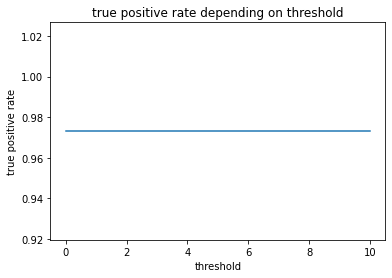

threshold for vocabulary ignore terms:  0  true positive rate: 0.9731543624161074
threshold for vocabulary ignore terms:  1  true positive rate: 0.9731543624161074
threshold for vocabulary ignore terms:  2  true positive rate: 0.9731543624161074
threshold for vocabulary ignore terms:  3  true positive rate: 0.9731543624161074
threshold for vocabulary ignore terms:  4  true positive rate: 0.9731543624161074
threshold for vocabulary ignore terms:  5  true positive rate: 0.9731543624161074
threshold for vocabulary ignore terms:  6  true positive rate: 0.9731543624161074
threshold for vocabulary ignore terms:  7  true positive rate: 0.9731543624161074
threshold for vocabulary ignore terms:  8  true positive rate: 0.9731543624161074
threshold for vocabulary ignore terms:  9  true positive rate: 0.9731543624161074
threshold for vocabulary ignore terms:  10  true positive rate: 0.9731543624161074
Best threshold:  0  true positive rate:  0.9731543624161074


In [68]:
#step 3:
plt.plot(true_positive_rate.keys(), true_positive_rate.values())
plt.title('true positive rate depending on threshold')
plt.ylabel('true positive rate')
plt.xlabel('threshold')
plt.show()
for min_df in true_positive_rate.keys():
    print("threshold for vocabulary ignore terms: ", min_df, " true positive rate:", true_positive_rate[min_df])
threshold = max(true_positive_rate,  key=true_positive_rate.get)
print("Best threshold: ", threshold, " true positive rate: ", true_positive_rate[threshold])


# Decision Tree
Analyze important words to categorize the documents
**decision_tree**: max depth with the threshold with criterion entropy (information gain)
#### variables from previous methods
**xtrain_v**: vectorized trained data using fit_transform() a.k.a it is learned\
**xtest_v**: vectorized test data using transform() a.k.a not learned
**y_train**: label for xtrain
**y_test**: label for xtest

In [69]:
xtrain_v, len(label)

(<1192x5375 sparse matrix of type '<class 'numpy.int64'>'
 	with 141661 stored elements in Compressed Sparse Row format>,
 5375)

In [70]:
import sklearn
from sklearn.ensemble import RandomForestClassifier
xtrain_a = xtrain_v.toarray()
xtest_a = xtest_v.toarray()
N,D = xtrain_a.shape

In [71]:
def predict_data_forest(clf):
    predictions = clf.predict(xtest_a)
    count = 0
    for i in range (len(predictions)):
        if predictions[i]== y_test[i]:
            count=count+1
    return count/len(predictions)

### find the random forest that can predict the data best


In [72]:
prediction_forest = {}
for depth in range(15, 16):
    for state in range(3):
        clf = RandomForestClassifier(max_depth=depth, random_state=state)
        clf.fit(xtrain_a, y_train)
        prediction_forest[(depth,state)] = predict_data_forest(clf)
        print("depth: ", depth, " state: ", state, " accuracy: ", prediction_forest[(depth,state)])
best_forest = max(prediction_forest,  key=prediction_forest.get)
print("The best prediction depth and random_state is ", best_forest, " which has a prediction rate of ",
     prediction_forest[best_forest])

depth:  10  state:  0  accuracy:  0.9295302013422819
depth:  10  state:  1  accuracy:  0.9463087248322147
depth:  10  state:  2  accuracy:  0.9395973154362416
depth:  10  state:  3  accuracy:  0.9429530201342282
depth:  10  state:  4  accuracy:  0.9362416107382551
depth:  10  state:  5  accuracy:  0.9563758389261745
depth:  10  state:  6  accuracy:  0.9328859060402684
depth:  10  state:  7  accuracy:  0.9395973154362416
depth:  10  state:  8  accuracy:  0.9429530201342282
depth:  10  state:  9  accuracy:  0.9328859060402684
depth:  11  state:  0  accuracy:  0.9395973154362416
depth:  11  state:  1  accuracy:  0.9362416107382551
depth:  11  state:  2  accuracy:  0.9395973154362416
depth:  11  state:  3  accuracy:  0.9530201342281879
depth:  11  state:  4  accuracy:  0.9463087248322147
depth:  11  state:  5  accuracy:  0.9530201342281879
depth:  11  state:  6  accuracy:  0.9463087248322147
depth:  11  state:  7  accuracy:  0.9496644295302014
depth:  11  state:  8  accuracy:  0.9295302013

In [73]:
depth, state = best_forest[0], best_forest[1]
decision_tree = RandomForestClassifier(max_depth=depth, random_state=state)
decision_tree.fit(xtrain_a, y_train)
importance = decision_tree.feature_importances_

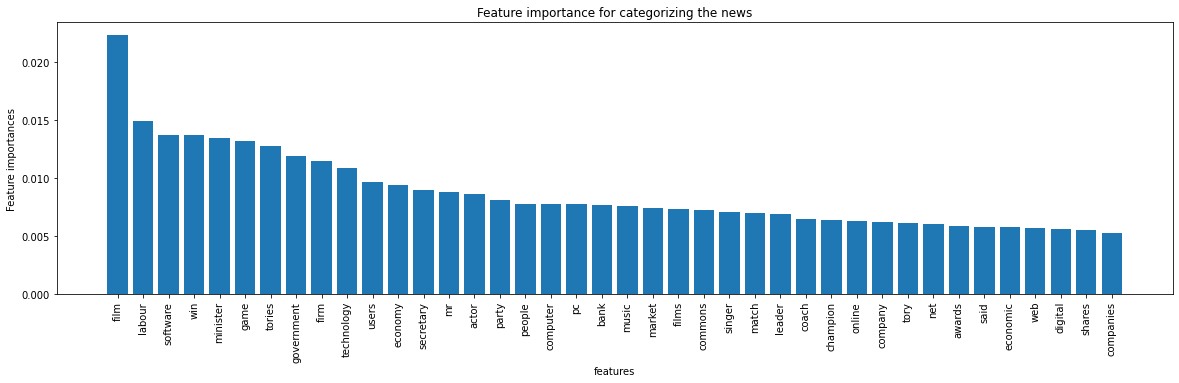

((5375,), 5375)

In [74]:
order = pd.Index(-1*importance).argsort()
sorted_label = np.array(label)[order]
sorted_importance = importance[order]
fn = 40
plt.figure(figsize=(20,5))
plt.bar(sorted_label[:fn], sorted_importance[:fn])
plt.xticks(sorted_label[:fn], rotation='vertical')
plt.title("Feature importance for categorizing the news")
plt.ylabel("Feature importances")
plt.xlabel("features")
plt.show()
importance.shape, len(label)

# Use feature importance on Detecting Model
**sorted_label**: impornat words\
**sorted_importance**: importance of those words\
**xtrain_v/x_test_v**: vectorized data by **cv**\
1. store xtrain_v in dataframes and drop not feature important words

In [75]:
xtrain_v, y_train

(<1192x5375 sparse matrix of type '<class 'numpy.int64'>'
 	with 141661 stored elements in Compressed Sparse Row format>,
 1007    4
 521     0
 863     4
 1321    2
 1194    2
        ..
 360     0
 709     3
 439     3
 174     0
 1146    3
 Name: Category, Length: 1192, dtype: int64)

In [76]:
def generate_non_important(fn):
    sorted_label_list = sorted_label[:fn].tolist()
    vocab = cv.vocabulary_.items()
    non_important = []
    for key, value in vocab:
        if key not in sorted_label_list:
            non_important.append(key)
    return text.ENGLISH_STOP_WORDS.union(non_important)

In [77]:
def predict_data_from_reduced(stopwords_appended):
    cv = text.CountVectorizer(stop_words=stopwords_appended, min_df = 6)
    xtrain_vr = cv.fit_transform(x_train)
    label = cv.get_feature_names()
    xtest_vr = cv.transform(x_test)
    mnb = MultinomialNB()
    mnb.fit(xtrain_vr,y_train)
    predictions = mnb.predict(xtest_vr)
    count = 0
    for i in range (len(predictions)):
        if predictions[i]== y_test[i]:
            count=count+1
    return count/len(predictions)

In [89]:
#generates the prediction
original_stop_word = cv.stop_words_
feature_non_dict = {}
for k in range(3000, 5000):
    stopwords_appended = generate_non_important(k)
    feature_non_dict[k] = predict_data_from_reduced(stopwords_appended)
best_featured_num = max(feature_non_dict,  key=feature_non_dict.get)
print("The best number to consider while avoiding overffiting is ", best_featured_num,
      "with prediction rate,", feature_non_dict[best_featured_num])

The best number to consider while avoiding overffiting is  3461 with prediction rate, 0.9798657718120806


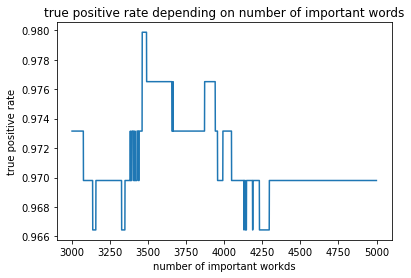

In [90]:
plt.plot(feature_non_dict.keys(), feature_non_dict.values())
plt.title('true positive rate depending on number of important words')
plt.ylabel('true positive rate')
plt.xlabel('number of important workds')
plt.show()

In [91]:
feature_non_dict = {}
for k in range(2000, 3500):
    stopwords_appended = generate_non_important(k)
    feature_non_dict[k] = predict_data_from_reduced(stopwords_appended)
best_featured_num = max(feature_non_dict,  key=feature_non_dict.get)
print("The best number to consider while avoiding overffiting is ", best_featured_num,
      "with prediction rate,", feature_non_dict[best_featured_num])

The best number to consider while avoiding overffiting is  2690 with prediction rate, 0.9798657718120806


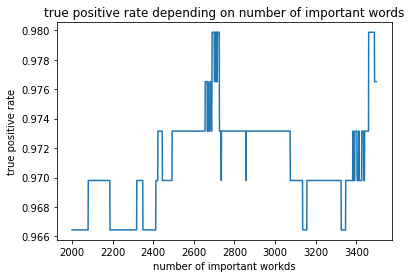

In [92]:
plt.plot(feature_non_dict.keys(), feature_non_dict.values())
plt.title('true positive rate depending on number of important words')
plt.ylabel('true positive rate')
plt.xlabel('number of important workds')
plt.show()

In [79]:
"""
r,c = limited_data.shape
documents = []
len_documents = []
y_train = []
MAX_DOCUMENTS = 3000
for i in range(r):
    document = str(limited_data.loc[i,'Text'])
    y_train.append(str(limited_data.loc[i,'Category']))
    len_documents.append(len(document))
    documents.extend(document)
documents.extend(keywordDF['keywords'][:10].tolist()) #extend keywords
#Form bag of words model using words used at least 10 times
v = text.CountVectorizer(stop_words=stop_words, min_df = 10)
print(documents)
train = v.fit_transform(documents).toarray()
x_train = []
for i in len(len_documents) - 1:
    x_train.append(train[:len_documents[i], :])#store in train_x
gnb = GaussianNB()
label = gnb.fit(data[x_train, y_train]).predict(train[len_documents[-1]:])
print(label)#X_test: keywords, x_train, y_train: trained data
"""

"\nr,c = limited_data.shape\ndocuments = []\nlen_documents = []\ny_train = []\nMAX_DOCUMENTS = 3000\nfor i in range(r):\n    document = str(limited_data.loc[i,'Text'])\n    y_train.append(str(limited_data.loc[i,'Category']))\n    len_documents.append(len(document))\n    documents.extend(document)\ndocuments.extend(keywordDF['keywords'][:10].tolist()) #extend keywords\n#Form bag of words model using words used at least 10 times\nv = text.CountVectorizer(stop_words=stop_words, min_df = 10)\nprint(documents)\ntrain = v.fit_transform(documents).toarray()\nx_train = []\nfor i in len(len_documents) - 1:\n    x_train.append(train[:len_documents[i], :])#store in train_x\ngnb = GaussianNB()\nlabel = gnb.fit(data[x_train, y_train]).predict(train[len_documents[-1]:])\nprint(label)#X_test: keywords, x_train, y_train: trained data\n"

# Evaluation
store predicted data and evaluation from user whether the label is valid
Evaluate the True Positive Rate and Fale Positive Rate by ROC curve
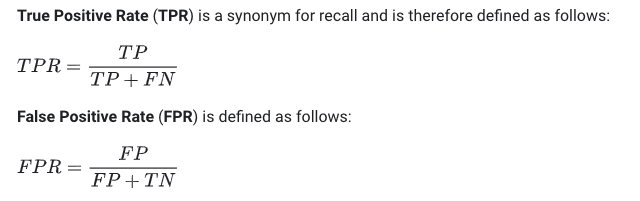

In [80]:
#get DataFrame from csv
#add current data
#do functions
#store data to csv